In [1]:
import sys
sys.path.append('/content/adult.csv')
from utils import * 
from model import *


In [2]:
import matplotlib.pyplot as plt
def plot_acc_fairness(model):
    f, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=False)
    curr_ax = axes[0]
    curr_ax.plot( [x[0] for x in model.logs])
    curr_ax.set_ylabel('Model Accuracy', fontsize = 20)
    curr_ax.set_xlabel('Epochs', fontsize = 20)
    curr_ax.tick_params(axis="x", labelsize=15) 
    plt.show()
    
    

In [3]:
from utils import * 
from model import *
pd00, label_name, feats = load_data('census')
seed = 0
X_train, X_val, X_test, y_train, y_val, y_test = get_data_loader(pd00, feats, label_name, seed=seed)
params = {}
params['X_train'] = X_train
params['X_val'] = X_val
params['y_train'] = y_train
params['y_val'] = y_val
params['device'] = 'cpu'
params['bs'] = 256
options = {}
options['model_lr'] = 1e-3

options['epochs'] = 400
input_dim = X_train.shape[1]
options['input_size'] = input_dim




In [4]:
## GRID SEARCH TO SELECT OPTIMAL NETWORK STRUCTURE
grid_search_list = []
options['acc_only'] = True #  Accuracy as the Metric to select Optimal Network  
options['step_size'] = 0.0 # Disable step-size if you only need to learn a simple classifier (w.o fairness)
options['lr_mult'] = 0  # also need to set the initial Multipliers to be zeroes

for n_gen in [int(x) for x in np.linspace(input_dim / 2, input_dim - 1, 2)]:
    for n_z in [int(x) for x in np.linspace(input_dim / 5 + 1, input_dim / 2, 2)]:
        if n_z < n_gen:
            curr_options = copy.deepcopy(options)
            curr_options['model_params'] = {'input_size': input_dim, 'gen_nnodes_list': [n_gen],
                                            'z1_nnodes_list': [n_z], \
                                            'z0_nnodes_list': [n_z]}
            grid_search_list.append(curr_options)

### 1. A simple Deep Network Classifier

In [5]:
# A simple deep network classifier without fairness
mc_model = LDSharedModel(params)
mc_model.hyper_opt(grid_search_list)

{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [6], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}}
{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [11], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}}
{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [11], 'z1_nnodes_list': [6], 'z0_nnodes_list': [6]}}


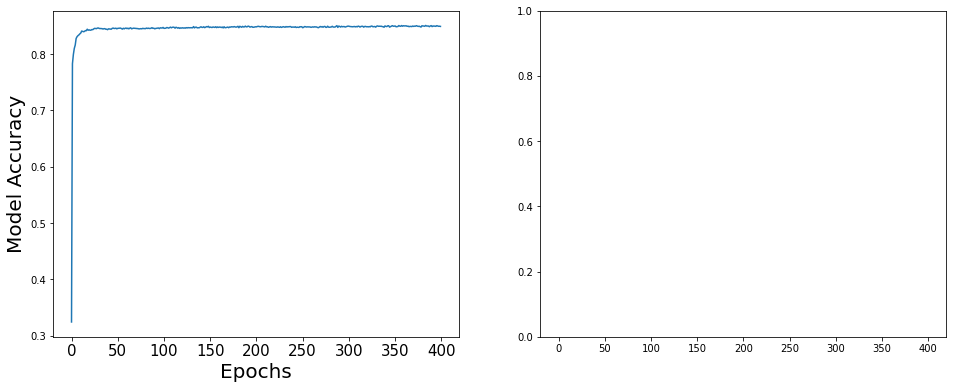

In [6]:
plot_acc_fairness(mc_model)

In [7]:
best_options = mc_model.best_options
print(best_options)

{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [6], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}, 'return_output': True}




### 2.   Use best_option to train Basic Net




In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_utils import *
from dataset import Dataset
from basicnet import Net
import matplotlib.pyplot as plt


device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

params = {'benchmark': 'adult', 'maxlen': 0, 'batch_size': 500,
          'split': [0.7, 0.2, 0.1], 'seed': 0,
          'epochs': 100, 'lr': 0.001}
data = Dataset(params, 'train', device)
model = Net(data.nfeatures, [10,5])

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

In [9]:
from cache import Cache
cache = Cache(2) # we'll use only the hidden layers

for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        h2 = model.get_embedding(x, 1) 
        cache.store(h2, 1)

        h3 = model.get_embedding(x, 2) 
        cache.store(h3, 2)
        cache.store_label(y)

In [10]:
from autoencoder import AutoEncoder
ae1 = AutoEncoder(model._l_dim[1], 2)
ae2 = AutoEncoder(model._l_dim[2], 2)

ae_loss1 = nn.MSELoss()
ae_loss2 = nn.MSELoss()
opt1 = optim.Adam(ae1.parameters(), lr=0.001)
opt2 = optim.Adam(ae2.parameters(), lr=0.001)

y1_loss=[]
y2_loss=[]

for epoch in range(5):#params['epochs']):
    for x1 in cache.embeddings[1]:
        opt1.zero_grad()
        x̃1 = ae1(x1)
        l1 = ae_loss1(x̃1, x1)
        l1.backward(retain_graph=True)
        opt1.step() 
        y1_loss.append(l1.item())
    
    for x2 in cache.embeddings[2]:
        opt2.zero_grad()
        x̃2 = ae2(x2)
        l2 = ae_loss2(x̃2, x2)
        l2.backward(retain_graph=True)
        opt2.step()
        y2_loss.append(l2.item())


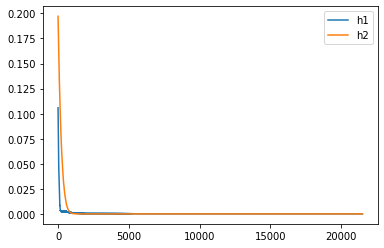

In [11]:
plt.plot(y1_loss)
plt.plot(y2_loss)
plt.legend(['h1', 'h2'])



###3.   (Test) Split stored caches and find neighbors



In [12]:
#This aims to split tensors so that batchsize will be equal to 1
from split import *
split_1 = split(cache.embeddings[1])
split_2 = split(cache.embeddings[2])
split_labels = split(cache.labels)

In [13]:
len(split_labels)

2111300

In [14]:
'''This aims to store the first and second element of the output tensor, in order to construct bins'''
'''a1 b1 represent the first and second element of the output from layer1'''
'''so as to a2 b2'''
from convert_to_list import *
a1, b1, freeze_layer1, a2, b2, freeze_layer2, each_label = convert(split_1, split_2, split_labels)

In [15]:
#seperate elements from output of layers with respect to their labels
#a1_0 represents for first element in layer1 with label 0
#b2_1 represents for second element in layer2 with label 1
import numpy as np
a1_0 = []
b1_0 = []
a2_0 = []
b2_0 = []
a1_1 = []
a2_1 = []
b1_1 = []
b2_1 = []
freeze_layer1_label0 = []
freeze_layer1_label1 = []
freeze_layer2_label0 = []
freeze_layer2_label1 = []
for i in range(len(each_label)):
  if each_label[i] == 0:
    a1_0.append(a1[i])
    b1_0.append(b1[i])
    a2_0.append(a2[i])
    b2_0.append(b2[i])
    freeze_layer1_label0.append(freeze_layer1[i])
    freeze_layer2_label0.append(freeze_layer2[i])
  if each_label[i] == 1:
    a1_1.append(a1[i])
    b1_1.append(b1[i])
    a2_1.append(a2[i])
    b2_1.append(b2[i])
    freeze_layer1_label1.append(freeze_layer1[i])
    freeze_layer2_label1.append(freeze_layer2[i])

###Histogram

In [16]:
# ''' Plot the 3d histograms of output from 2 layers with respect to their first'''
# ''' and second element and their corresponding labels'''

# from histogram_3d_both import *
# plot_his_3d_both(a1_0, b1_0, a1_1, b1_1, 0.12, 0.12, a1, b1, 'Histogram of output of AE1 (orange for label1, blue for label0)')
# plot_his_3d_both(a2_0, b2_0, a2_1, b2_1, 0.000001, 0.0001, a2, b2, 'Histogram of output of AE2 (orange for label1, blue for label0)')

In [17]:
# '''This aims to check the distribution of the data which is in highest bar in AE1 of AE2.'''

# '''Take out the index of data in highest bar in AE1 and use index to take out corresponding data in AE2'''
# from replot_highest6 import *
# row1, row2 = replot_highest(a1_0, b1_0, a2_0, b2_0)
# row3, row4 = replot_highest(a1_1, b1_1, a2_1, b2_1)

# '''Replot data extracted above in AE2 plot'''
# from histogram_3d import *
# plot_his_3d(row1, row2, 0.000001, 0.0001, a2_0, b2_0, 'histogram of data in highest bar in AE1 plotted in AE2 (label0)')
# plot_his_3d(a2_0, b2_0, 0.000001, 0.0001, a2_0, b2_0, 'Original histogram of AE2 (label0)')
# plot_his_3d(row3, row4, 0.000001, 0.0001, a2_1, b2_1, 'histogram of data in highest bar in AE1 plotted in AE2 (label1)')
# plot_his_3d(a2_1, b2_1, 0.000001, 0.0001, a2_1, b2_1, 'Original histogram of AE2 (label1)')

###Find Cluster and neighbors

In [18]:
#derive the testing set data, train it and store the output from the basicnet.
data_test = Dataset(params, 'test', device)
cache_test = Cache(2)
for epoch in range(params['epochs']):
    for (x, y) in data_test:
        (x, y) = x.to(device), y.to(device)
        h1_test = model.get_embedding(x, 1) 
        cache_test.store(h1_test, 1)

        h2_test = model.get_embedding(x, 2) 
        cache_test.store(h2_test, 2)
        cache_test.store_label(y)



In [19]:
#split test data so that each data points can be used
split1_test = split(cache_test.embeddings[1])
split2_test = split(cache_test.embeddings[2])
split_labels_test = split(cache_test.labels)

In [20]:
# # derive the output from AE
# layer_num = 1
# layer_test = layer1_test
# for i in range(len(layer_test)):
# 	if layer_num == 1:
# 		layer_test[i] = ae1.encode(layer_test[i])
# 	if layer_num == 2:
# 		layer_test[i] = ae2.encode(layer_test[i])

In [21]:
#convert the data to list which is used to compute epsilon of knn
a1_test, b1_test, freeze_layer1_test, a2_test, b2_test, freeze_layer2_test, labels_test = convert(split1_test, split2_test, split_labels_test)

In [54]:
freeze_layer1_enlarge = []
for index in range(len(freeze_layer1)):
  freeze_layer1_enlarge.append([freeze_layer1[index][0] * 1000000, freeze_layer1[index][1] * 1000000])

In [55]:
freeze_layer1_test_enlarge = []
for index in range(len(freeze_layer1_test)):
  freeze_layer1_test_enlarge.append([freeze_layer1_test[index][0] * 1000000, freeze_layer1_test[index][1] * 1000000])

In [56]:
from times3 import times
a1_enlarge = times(a1,1000000)
b1_enlarge = times(b1,1000000)
a2_enlarge = times(a2,1000000)
b2_enlarge = times(b2,1000000)


In [100]:
'''
instead of use KNN, we use small number as enlarging radius of our data to capture the nearest clusters.
we find data in centroid of layer in the range of a+- epsilon
'''
import time
start = time.time()
from enlarging_radius import *
layer1_label_pred, neighbor = get_label(1, False, 10, a1_enlarge, b1_enlarge, a2_enlarge, b2_enlarge, freeze_layer1_test_enlarge[:10000], each_label, freeze_layer1_enlarge, each_label, 1, 0.8)
end = time.time()
print(end - start)

51.690377712249756


In [118]:
import time
start = time.time()
layer_num = 1
use_cluster = False
box_num = 10
l1_first = a1_enlarge
l1_second = b1_enlarge
l2_first = a2_enlarge
l2_second = b2_enlarge
test_layer = freeze_layer1_test_enlarge[:1000]
cache_label = each_label
centroid = freeze_layer1_enlarge
confidence = each_label
percentage = 0.0000001
threshold = 0.8
#compute epsilon
e_a1 = (max(l1_first) - min(l1_first))*per*percentage
e_b1 = (max(l1_second) - min(l1_second))*per*percentage
e_a2 = (max(l2_first) - min(l2_first))*per*percentage
e_b2 = (max(l2_second) - min(l2_second))*per*percentage
neighbor = []

if layer_num == 1:
	e_a = e_a1 
	e_b = e_b1 
else:
	e_a = e_a2
	e_b = e_b2	

test_label = []
for i in range(len(test_layer)):
	confidence1 = 0
	confidence0 = 0
	for j in range(len(centroid)): 	
		#find the intersection of first and second element in centroid_list
		if (l1_first[i] - e_a) <= centroid[j][0] and centroid[j][0] <= (l1_first[i] + e_a):
			if (l1_second[i] - e_b) <= centroid[j][1] and centroid[j][1] <= (l1_second[i] + e_b):
				neighbor.append(centroid[j])
				if use_cluster == True:
					if j < box_num*box_num:
						confidence0 += confidence[j]	
					if j >= box_num*box_num:
						confidence1 += confidence[j]
				else:
				    if cache_label[j] == 0:
					    confidence0 += confidence[j] + 1	
				    else:
					    confidence1 += confidence[j]
	if (confidence1 + confidence0) == 0:
	    label = 'do not have neighbor in this range'
	else:
	    confidence_t = confidence0 + confidence1
	    confidence0 /= confidence_t
	    confidence1 = 1 - confidence0
	if confidence0 > threshold:
	    label = '0'
	elif confidence1 > threshold:
	    label = '1'
	else:
		label = 'not sure'

	test_label.append(label)
end = time.time()
print(end - start)



886.7887723445892


In [119]:
len(neighbor)

138500

In [120]:

correct = 0
miss = 0
no_neighbor = 0
for i in range(1000):
  if test_label[i] == 'not sure':
    miss += 1
  elif test_label[i] == 'do not have neighbor in this range':
    no_neighbor += 1
  elif int(test_label[i]) == int(labels_test[i]):
    correct += 1


In [121]:
accuracy = correct/len(test_label)
cache_miss = miss/len(test_label)
no = no_neighbor/len(test_label)

In [122]:
accuracy

0.618

In [ ]:

correct = 0
miss = 0
no_neighbor = 0
for i in range(5):
  if layer1_label_pred[i] == 'not sure':
    miss += 1
  elif layer1_label_pred[i] == 'do not have neighbor in this range':
    no_neighbor += 1
  elif int(layer1_label_pred[i]) == int(labels_test[i]):
    correct += 1


In [ ]:
accuracy = correct/len(layer1_label_pred)
cache_miss = miss/len(layer1_label_pred)
no = no_neighbor/len(layer1_label_pred)

In [68]:
accuracy

0.6666666666666666

In [123]:
cache_miss

0.036

In [124]:
no

0.0